In [1]:
%load_ext autoreload
%autoreload 2

# Computational model figure
## Note : 
NPG palettes available at https://nanx.me/ggsci/reference/pal_npg.html

### Imports

In [2]:
#from tqdm import tqdm
#import itertools

#from brian2 import *
import numpy as np
#from lmfit import Model, Parameters

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d
#import matplotlib.patheffects as PathEffects

import MotionClouds as mc

#import sys
#sys.path.append('..')

#from utils import data as ut_data
#from utils import plotting as ut_plot
#from utils import inputs as ut_inp

### Params

In [3]:
N_X, N_Y = 256, 256 # MotionClouds texture size (px)

n_e = 360 # number of excitatory nodes in a ring
n_i = n_e // 4 # number of inhibitory nodes in a ring

e_radius = 1 # radius of the excitatory ring
i_radius = .8 # radius of the inhibitory ring

e_color = r'#E64B35'  # excitatory color
i_color = r'#3C5488'  # inhibitory color

s_mult = 8 # size gain, relative to node coordinate
ring_spacing = 2. # spacing between the two rings

save = False # save the files ?
dpi = 250 # saving dpi

In [4]:
rad = lambda n, rad : np.array([rad * np.cos(np.arange(0,n) * 2 * np.pi / n),
                                rad * np.sin(np.arange(0,n) * 2 * np.pi / n)])
e_xs, e_ys = rad(n_e, e_radius)
i_xs, i_ys = rad(n_i, i_radius)

### MotionClouds texture generation

In [5]:
def generate_cloud(theta, b_theta, sf_0,
                   N_X, N_Y,
                   seed, contrast=1):
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)

    mc_i = mc.envelope_gabor(fx, fy, ft,
                             V_X=0., V_Y=0., B_V=0.,
                             sf_0=sf_0, B_sf=sf_0,
                             theta=theta, B_theta=b_theta)

    im_ = mc.rectif(mc.random_cloud(mc_i, seed=seed),
                    contrast=contrast)
    return im_[:, :, 0]

### Matplotlib functions

In [6]:
def recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                      xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=-.03):
    style = "Simple,tail_width=0.2,head_width=2,head_length=2"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., 2.5*np.e, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows // step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif) ,
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' %  .75,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
    
    for i0, x in enumerate(-lspace) :
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif ),
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.75 ,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)

In [7]:
def layer_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                    xs=e_xs, ys=e_ys, xs2=i_xs, ys2=i_ys, mult_connect = 4,
                    yfrom_rectif = 0., yto_rectif=-.03,
                 do_zero = False):
    style = "Simple,tail_width=0.2,head_width=2,head_length=2"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., np.e, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows // step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif) ,
                                      (xs2[int(idx*mult_connect)+x], ys2[int(idx*mult_connect)+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % .01,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
    
    for i0, x in enumerate( -lspace) :
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif ),
                                      (xs2[int(idx*mult_connect)+x], ys2[int(idx*mult_connect)+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.01,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
        
    if do_zero : 
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif ),
                                      (xs2[int(idx*mult_connect)], ys2[int(idx*mult_connect)] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.01,
                                      alpha=alphas[0],
                                      **kw)
        ax.add_patch(arr)

In [8]:
def forward_connect(idx=180, n_arrows=40, step_arrows=3, color=e_color, lw = .3,
                    xs=e_xs, ys=e_ys, xs2=i_xs, ys2=i_ys, mult_connect = 4,
                    add_idx = 10,  yto_rectif=-.03):
    lspace = np.arange(-n_arrows, n_arrows, step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        ax.plot((xs[idx+x], xs2[int(mult_connect*idx)+x+add_idx]),
                (ys[idx+x], ys2[int(mult_connect*idx)+x+add_idx]+yto_rectif),
                color=color, linestyle=(0, (5, 7)),
                linewidth=lw, zorder=-1)
        ax.arrow(xs2[int(mult_connect*idx)+x+add_idx],
                 ys2[int(mult_connect*idx)+x+add_idx]+yto_rectif,
                 0, .005,
                    color=color, linewidth=.1 * (-ys[idx+x]+np.abs(np.min(ys))),
                    head_width=.0075, zorder=-1)

### Figure

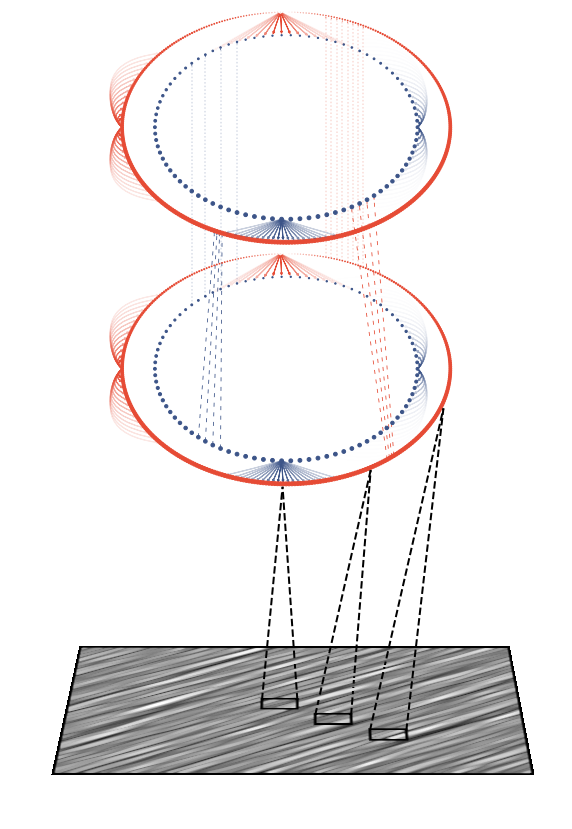

In [11]:
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])


# Drawing the neural network --------------------------------------
ax = plt.subplot(gs[0])

# Scattering nodes, first layer
ax.scatter(e_xs, e_ys, c=e_color,
           s=s_mult*(-e_ys + np.abs(np.min(e_ys))),
           zorder=500)
ax.scatter(i_xs, i_ys, c=i_color,
           s=s_mult*(-i_ys + np.abs(np.min(e_ys))),
           zorder=500)

# Nodes, second layer
ax.scatter(e_xs, e_ys+2.1, c=e_color,
           s=s_mult * (-e_ys+np.abs(np.min(e_ys)+ring_spacing)))
ax.scatter(i_xs, i_ys+2.1, c=i_color,
           s=s_mult * (-i_ys+np.abs(np.min(e_ys)+ring_spacing)))



# Recurrent connections
# Connect L1 exc-exc nodes
recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=0.)

# Connect L2 exc-exc nodes
recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3,color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 2.1, yto_rectif=2.1)

# Connect L1 inh-inh nodes
recurrent_connect(idx=0, n_arrows=20, i0_arrows=1, step_arrows=1, color=i_color,
                  xs=i_xs, ys=i_ys, yfrom_rectif = 0., yto_rectif=0.)

# Connect L2 inh-inh nodes
recurrent_connect(idx=0, n_arrows=20, i0_arrows=1, step_arrows=1, color=i_color,
                  xs=i_xs, ys=i_ys, yfrom_rectif = 2.1, yto_rectif=2.1)


# Heterogeneous connections
# Connect L1 exc-inh nodes        
layer_connect(idx=92, n_arrows=8, i0_arrows=1, step_arrows=1, color=e_color,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                yfrom_rectif = 0., yto_rectif= 0., do_zero = True)

# Connect L2 exc-inh nodes
layer_connect(idx=92, n_arrows=8, i0_arrows=1, step_arrows=1, color=e_color,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                yfrom_rectif = 2.1, yto_rectif= 2.1, do_zero = True)

# Connect L1 inh-exc nodes
layer_connect(idx=67, n_arrows=20, i0_arrows=1, step_arrows=2, color=i_color,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                yfrom_rectif = 0., yto_rectif= 0.)

# Connect L2 inh-exc nodes
layer_connect(idx=67, n_arrows=20, i0_arrows=1, step_arrows=2, color=i_color,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                yfrom_rectif = 2.1, yto_rectif= 2.108)


# Feedforward connections
# Connect L1 to L2 exc nodes
forward_connect(idx=70, n_arrows=8, step_arrows=2, color=e_color, lw = .3,
                xs=e_xs, ys=e_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 1,
                add_idx = 0, yto_rectif= 2.075)

# Connect L1 to L2 inh nodes
forward_connect(idx=32, n_arrows=4, step_arrows=2, color=i_color, lw = .3,
                xs=i_xs, ys=i_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = 1,
                add_idx = 0, yto_rectif= 2.075)

# Connect L1 inh to L2 exc nodes
forward_connect(idx=59, n_arrows=2, step_arrows=1, color=i_color, lw = .8,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                add_idx = 10, yto_rectif= 2.065)

# Connect L1 exc to L2 inh nodes
forward_connect(idx=310, n_arrows=2, step_arrows=1, color=e_color, lw = .8,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                add_idx = 0, yto_rectif= 2.065)



# Drawing the texture  ------------------------------------------
ax2 = plt.subplot(gs[1], projection='3d')

# The texture is displayed as a filled contour
xx, yy = np.meshgrid(np.arange(0, N_X), np.arange(0, N_Y))
im = generate_cloud(np.pi/4, np.pi/36, .1, N_X, N_Y, 42)

# Draw the squares directly on the texture to ensure perspective 
s = 20
wx = 2 # height in x axis
wy = 5 # width in y axis
x0s = [109, 139, 169] # bot left origin of the square
ytos = [122, 165, 198] # line destination, in y axis
ztos = [.21, .224, .273] # line destination, in z axis

for i0 in range(len(x0s)) :
    x0 = x0s[i0]
    yto = ytos[i0]
    zto = ztos[i0]
    
    im[x0:x0+s, x0:x0+wy] = 0
    im[x0:x0+wx, x0:x0+s] = 0
    im[x0:x0+s, x0+s:x0+s+wy] = 0
    im[x0+s:x0+s+wx, x0:x0+s+wy] = 0
    
    ax2.plot((x0+5, 126), (x0+.5, yto), (0, zto), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')
    ax2.plot((x0+5, 126), (x0+20.5, yto), (0, zto), clip_on=False, color='k', zorder=100,
             linewidth=2, linestyle='--')


# Circle the texture with a black square
s = N_X - 2
x0, wx, wy = 0, 2, 4
im[0:s, 0:wy] = 0
im[0:wx, 0:s] = 0
im[0:s, s-2:s+wy] = 0
im[0+s:s+wx, 0:s+wy] = 0

ax2.contourf(xx, yy, im, levels = 125,  offset=0., cmap='gray', zorder=-1)




# Setting up the plot  ------------------------------------------
ax.set_xlim(-1.7, 1.7)
ax.set_ylim(-1.05, 3.15)
ax.axis('off')

ax2.set_zlim(-.08, .1)
ax2.view_init(elev=40, azim=.2)
ax2.dist = 6.
ax2.axis('off')


plt.subplots_adjust(hspace=.25)
plt.show()

if save :
    fig.savefig('figure.pdf', format='pdf', bbox_inches='tight', dpi = dpi)
    fig.savefig('figure.png', format='png', bbox_inches='tight', dpi = dpi)